In [47]:
from trainer import QLearn
import gymnasium as gym

EPISODES = 1000000

env = gym.make("Blackjack-v1", render_mode="rgb_array")

q_learn = QLearn(env, alpha=0.1, gamma=1, epsilon=1, epsilon_decay=0.999995, min_epsilon=0.01)
rewards = q_learn.train(episodes=EPISODES, stats_interval=500)

New max of 1.0 in episode 1
Episodes (0, 499): Avg Reward- -0.374 Epsilon- 0.997503116163028
Episodes (500, 999): Avg Reward- -0.366 Epsilon- 0.9950124667549526
Episodes (1000, 1499): Avg Reward- -0.406 Epsilon- 0.9925280362091273
Episodes (1500, 1999): Avg Reward- -0.352 Epsilon- 0.9900498089977742
Episodes (2000, 2499): Avg Reward- -0.384 Epsilon- 0.9875777696318906
Episodes (2500, 2999): Avg Reward- -0.402 Epsilon- 0.9851119026611449
Episodes (3000, 3499): Avg Reward- -0.366 Epsilon- 0.9826521926737819
Episodes (3500, 3999): Avg Reward- -0.402 Epsilon- 0.9801986242965315
Episodes (4000, 4499): Avg Reward- -0.398 Epsilon- 0.9777511821945032
Episodes (4500, 4999): Avg Reward- -0.384 Epsilon- 0.9753098510711018
Episodes (5000, 5499): Avg Reward- -0.354 Epsilon- 0.9728746156679233
Episodes (5500, 5999): Avg Reward- -0.348 Epsilon- 0.9704454607646615
Episodes (6000, 6499): Avg Reward- -0.37 Epsilon- 0.9680223711790155
Episodes (6500, 6999): Avg Reward- -0.376 Epsilon- 0.9656053317665924


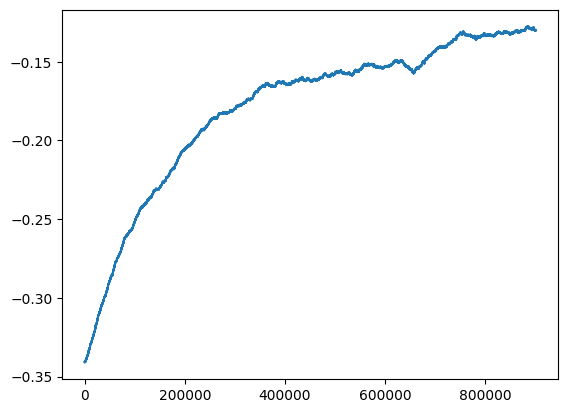

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

plt.figure()
plt.plot(moving_average(rewards, int(EPISODES/10)))

In [37]:
from IPython.display import HTML

HTML(q_learn.playback())

Playback Return: 1.0


In [49]:
q_learn.eval(episodes=100000)

Average Return over 100000 episodes: -0.10675


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import deque

class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
from trainer import DDQN
import gymnasium as gym
EPISODES = 200
gym.make("Blackjack-v1", render_mode="rgb_array")
ddqn = DDQN(env, QNetwork, buffer_size=100000, batch_size=32,
                    gamma=0.99, lr=1e-3, tau=1e-3, epsilon_start=1.0, 
                    epsilon_end=0.01, epsilon_decay=0.995,
                    target_update_interval=100)
rewards, losses = ddqn.train(episodes=EPISODES, stats_interval=50)

Episodes (0, 49): Avg Reward- 23.94 Epsilon- 0.778312557068642
Episodes (50, 99): Avg Reward- 55.38 Epsilon- 0.6057704364907278
Episodes (100, 149): Avg Reward- 76.42 Epsilon- 0.47147873742168567
Episodes (150, 199): Avg Reward- 86.08 Epsilon- 0.3669578217261671


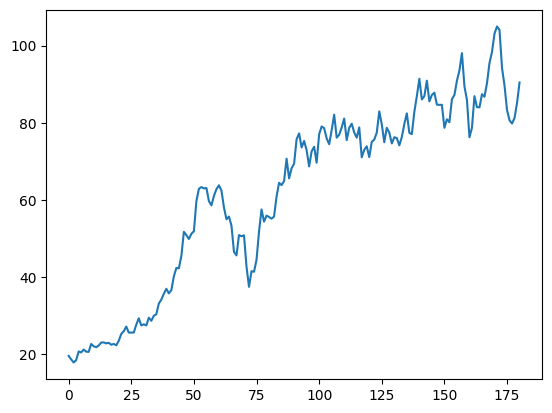

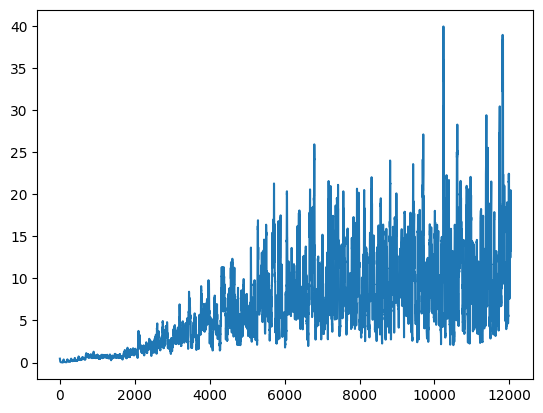

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

plt.figure()
plt.plot(moving_average(rewards, int(EPISODES/10)))
plt.figure()
plt.plot(moving_average(losses, int(EPISODES/10)))

In [10]:
from IPython.display import HTML

HTML(ddqn.playback())

Playback Return: 239.0


In [12]:
ddqn.eval(episodes=100)

Average Return over 100 episodes: 240.72
